# Used Cars Price Prediction

In [1]:
# Dependencies & Imports
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 999)

In [2]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
train_df = pd.read_csv('data/train-data.csv').drop('Unnamed: 0', axis=1)

### Dataset description:
* `Name`: The brand and model of the car.
* `Location`: The location in which the car is being sold or is available for purchase.
* `Year`: The year or edition of the model.
* `Kilometers_Driven`: The total kilometres driven in the car by the previous owner(s) in KM.
* `Fuel_Type`: The type of fuel used by the car. (Petrol / Diesel / Electric / CNG / LPG)
* `Transmission`: The type of transmission used by the car. (Automatic / Manual)
* `Owner_Type`: Whether the ownership is Firsthand, Second hand or other.
* `Mileage`: The standard mileage offered by the car company in kmpl or km/kg
* `Engine`: The displacement volume of the engine in cc.
* ` Power`: The maximum power of the engine in bhp.
* `Seats`: The number of seats in the car.
* `New_Price`: The price of a new car of the same model.
* `Price`: The price of the used car in INR Lakhs.

In [5]:
train_df.head(2)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50


In [6]:
train_df.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


In [7]:
train_df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

### Data Preprocessing
### Data Imputation
* `Mileage`<br>As printed above, there are only 2 missing values in this column. Looking into these two entries, they do not seem anamolous in other properties, therefore we simply impute them with the mean values from the rest of the entries. 
* `Engine`, `Power`, `Seats`<br>These attributes have relatively more missing values compared to the above. These are also believed to have some relation to other properties, therefore, instead of simply imputing them with common statistical values, we employ KNN imputation to impute these columns accordingly.
* `New_Price`<br>86% of entries in training set's `New_Price` column is missing. Because the missing percentage is too high, it is believed that it would not be as helpful in our prediction task. We remove this attribute going forward.

### Data Cleaning & Feature Engineering
* As given in the dataset statement, there are two units under `Mileage`, i.e. kmpl or km/kg. Specifically, kmpl stands for kilometers per liter while km/kg means kilometers per kilogram. In terms of liquid's unit consumption, i.e. fuel that we are discussing here: $1\ liter = 1\ kilogram$ <br>Therefore, for these are the only two units provided in all entries, we can simply drop the units and leave the `Mileage` column with numerical values.

In [8]:
print(train_df.isnull().sum().New_Price/len(train_df))

0.8631001827546104


In [9]:
def data_preprocessing(df):
    
    # data cleaning
    
    # Mileage
    idx = df.Mileage.loc[pd.isna(df.Mileage)==False].index
    df.Mileage.iloc[idx] = df.Mileage.iloc[idx].apply(lambda x: float(re.findall("[0-9]+\.*[0-9]*", x)[0]))
    
    # Engine
    idx = df.Engine.loc[pd.isna(df.Engine)==False].index
    df.Engine.iloc[idx] = pd.to_numeric(df.Engine.iloc[idx].apply(lambda x:x[:-2]))
    
    # Power
    df.Power = df.Power.replace('null bhp', np.nan)
    idx = df.Power.loc[pd.isna(df.Power)==False].index
    df.Power.iloc[idx] = pd.to_numeric(df.Power.iloc[idx].apply(lambda x:x[:-3]))

    
    # Seats
    idx = df.Seats.loc[pd.isna(df.Seats)==False].index
    df.Seats.iloc[idx] = df.Seats.iloc[idx].astype(int)
    
    # data imputation
    
    # define imputers
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_knn = KNNImputer(missing_values = np.nan, n_neighbors = 3)
    
    df['Mileage'] = imp_mean.fit_transform(df[['Mileage']])
    df[['Engine', 'Power', 'Seats']] = imp_knn.fit_transform(df[['Engine', 'Power', 'Seats']])
    
    # drop New_Price
    df.drop('New_Price', axis=1, inplace = True)
    
    return df


In [10]:
def feature_engineer(df):
    
    # Name - get brand name
    df['Name'] = df['Name'].apply(lambda x: x.split()[0])
    df = df.rename(columns = {'Name': 'Brand'})
    
    # Owner_Type
    enc = OrdinalEncoder(categories=[['Fourth & Above','Third', 'Second','First']])
    df['Owner_Type'] = enc.fit_transform(df[['Owner_Type']])
    
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = list(df.select_dtypes(include=['number']).columns)
    
    # one hot encode catgorical columns
    ohe = pd.get_dummies(df[cat_cols])
        
    df = df.drop(list(cat_cols), axis=1)
    df = df.join(ohe)
    
    # numerical columns
    mms = MinMaxScaler()
    df['Year'] = mms.fit_transform(df[['Year']])

    num_cols = [i for i in num_cols if i != 'Year']
    std = StandardScaler()
    df[num_cols] = std.fit_transform(df[num_cols])
 
    return df
    

In [11]:
train_X = data_preprocessing(train_df)

#### Perform EDA before feature engineering

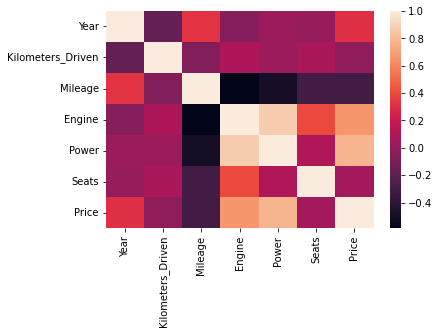

In [12]:
plt.figure()
sns.heatmap(train_X.corr())
plt.show()

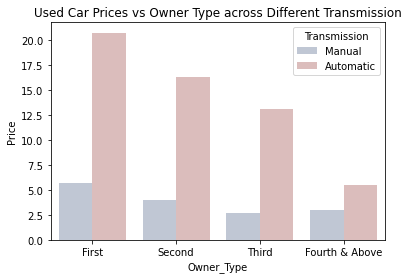

In [13]:
plt.figure()
sns.barplot(x=train_X.Owner_Type, y=train_X.Price, hue=train_X.Transmission, ci=None, palette="vlag", order=['First', 'Second', 'Third', 'Fourth & Above'])
plt.title('Used Car Prices vs Owner Type across Different Transmission')
plt.show()

In [14]:
display_cols = ['Kilometers_Driven','Mileage', 'Engine','Power']

<Figure size 432x288 with 0 Axes>

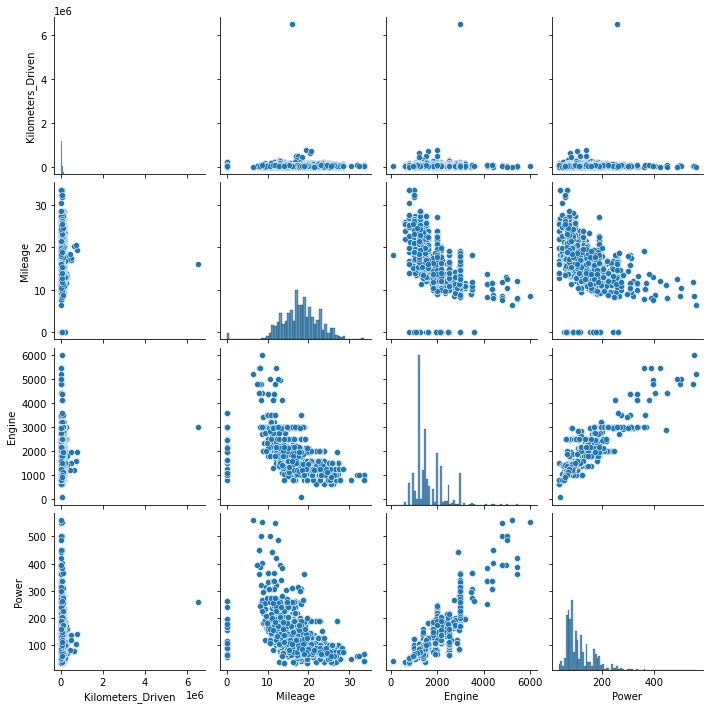

In [15]:
plt.figure()
sns.pairplot(train_X[display_cols])
plt.show()

<Figure size 432x288 with 0 Axes>

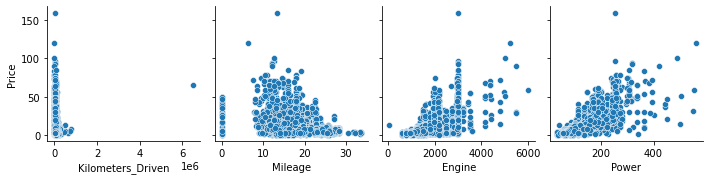

In [16]:
plt.figure()
sns.pairplot(train_X[display_cols].assign(Price=train_X.Price), 
            x_vars=display_cols, y_vars='Price', diag_kind=None)
plt.show()

In [17]:
brand_cnt = train_X.Name.apply(lambda x: x.split()[0]).value_counts()
brand_cnt

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Smart               1
Ambassador          1
Bentley             1
Isuzu               1
Lamborghini         1
Name: Name, dtype: int64

Counts < 100 are grouped in "Others"

In [18]:
brand_cnt_u = brand_cnt.loc[:'Chevrolet'].append(pd.Series(brand_cnt.loc['Nissan':].sum(), index=['Others'])).sort_values()

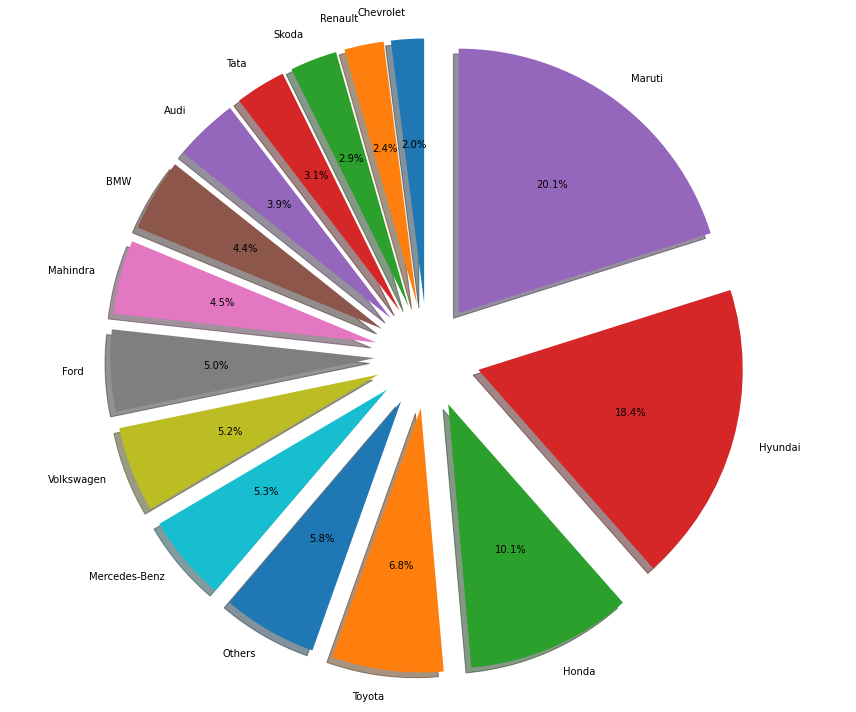

In [19]:
fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.pie(brand_cnt_u, explode=[0.2]*len(brand_cnt_u), labels=brand_cnt_u.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

#### Feature Engineer Data

In [20]:
train_X = train_df.drop('Price', axis=1)
train_y = train_df.Price

In [21]:
train_X = feature_engineer(train_X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42)

In [23]:
print('There are a total of {} listings in the training data, and {} entries in the testset.'.format(X_train.shape[0], X_test.shape[0]))

There are a total of 4213 listings in the training data, and 1806 entries in the testset.


### Modeling

In [24]:
param_grid = {
    'n_estimators':[20, 50, 75],
    'max_depth': np.arange(7, 10),
    'min_samples_leaf': [1, 2, 3]
}

In [25]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

In [26]:
grid = GridSearchCV(rf, param_grid, scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1, refit='r2', cv=3, verbose=1, return_train_score=True)

In [27]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    5.5s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([7, 8, 9]),
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [20, 50, 75]},
             refit='r2', return_train_score=True,
             scoring=['neg_mean_squared_error', 'r2'], verbose=1)

In [28]:
# pd.DataFrame(grid.cv_results_)

In [29]:
grid.best_estimator_

RandomForestRegressor(max_depth=9, min_samples_leaf=2, n_estimators=20,
                      n_jobs=-1, random_state=42)

In [30]:
grid.best_score_

0.879148378588185

In [31]:
y_pred = grid.predict(X_test)

In [32]:
r2_score(y_test, y_pred)

0.878765986947409

In [33]:
X_train.shape

(4213, 56)

Here, we try out the special feature enabled by random forest: feature importance.<br> There are 56 features in total after feature engineering, and we pick the top 20 most important features to try out for refitting. 

It is seen that model fitting on these 20 features alone has a slightly lower r2 training score than that which includes all features. However, it is more robust where the test score is actually higher than the prior.

Printed out below, it is shown that these top 20 "most important" features include engineered features from one hot encoding: such as car brand being Mercedes-Benz, etc. or where the location of sale was carried. While these information may be important on determining the sale price, on the other hand, extracting only these "scattered" attributes, and fitting a new model on them is understanable to have a worse performance on the train set (because e.g. in this case, there is no comparison to other brands or locations) --> because in this case the training set has more information the model can learn from.

However, what matters and is more important in most cases, is the model's ability to generalize to unseen data. By including only "the most important" features, our model is able to establish a higher r2 score on the test set.



In [34]:
important_idx = pd.Series(grid.best_estimator_.feature_importances_).sort_values(ascending=False)[:20].index
important_feat = list(pd.Series(X_train.columns).iloc[important_idx])

In [35]:
important_feat

['Power',
 'Year',
 'Kilometers_Driven',
 'Engine',
 'Mileage',
 'Brand_Land',
 'Location_Hyderabad',
 'Seats',
 'Transmission_Manual',
 'Brand_Mercedes-Benz',
 'Brand_Mini',
 'Brand_Audi',
 'Location_Delhi',
 'Fuel_Type_Diesel',
 'Brand_Jaguar',
 'Location_Kochi',
 'Location_Coimbatore',
 'Transmission_Automatic',
 'Location_Bangalore',
 'Fuel_Type_Petrol']

In [36]:
X_train2 = X_train[important_feat]
X_test2 = X_test[important_feat]

In [37]:
grid2 = grid
grid2.fit(X_train2, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  66 out of  81 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    3.4s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([7, 8, 9]),
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [20, 50, 75]},
             refit='r2', return_train_score=True,
             scoring=['neg_mean_squared_error', 'r2'], verbose=1)

In [38]:
grid2.best_estimator_

RandomForestRegressor(max_depth=9, min_samples_leaf=2, n_estimators=20,
                      n_jobs=-1, random_state=42)

In [39]:
grid2.best_score_

0.876561357009899

In [40]:
y_pred2 = grid2.predict(X_test2)

In [41]:
r2_score(y_test, y_pred2)

0.8800794320092656

For visualization: 

* Look into cv results
    * In sklearn: the higher return values are better than lower return values (so: neg_mean_squared_error)

In [42]:
grid1_cvresult = pd.DataFrame(grid.cv_results_)
grid2_cvresult = pd.DataFrame(grid2.cv_results_)

In [43]:
grid1_cvresult

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,mean_train_r2,std_train_r2
0,0.074054,0.000595,0.040956,0.005752,7,1,20,"{'max_depth': 7, 'min_samples_leaf': 1, 'n_est...",-13.056797,-17.228286,-22.723803,-17.669629,3.958858,25,-7.388991,-7.146144,-5.921364,-6.818833,0.642304,0.878297,0.874157,0.830351,0.860935,0.021692,26,0.945443,0.940772,0.951504,0.945906,0.004393
1,0.174901,0.010361,0.052089,0.005287,7,1,50,"{'max_depth': 7, 'min_samples_leaf': 1, 'n_est...",-12.562833,-17.105850,-22.358034,-17.342239,4.002366,21,-6.793394,-6.962316,-5.705714,-6.487141,0.556840,0.882901,0.875051,0.833082,0.863678,0.021871,21,0.949840,0.942296,0.953270,0.948469,0.004584
2,0.368556,0.040313,0.041333,0.004855,7,1,75,"{'max_depth': 7, 'min_samples_leaf': 1, 'n_est...",-12.448791,-17.367720,-22.358618,-17.391710,4.045706,22,-6.650030,-6.854483,-5.705672,-6.403395,0.500375,0.883964,0.873138,0.833077,0.863393,0.021887,23,0.950899,0.943190,0.953270,0.949120,0.004303
3,0.089666,0.015221,0.036007,0.020216,7,2,20,"{'max_depth': 7, 'min_samples_leaf': 2, 'n_est...",-11.661634,-17.268395,-21.889917,-16.939982,4.182131,16,-8.517252,-8.270885,-6.552880,-7.780339,0.873753,0.891301,0.873864,0.836576,0.867247,0.022826,16,0.937112,0.931450,0.946332,0.938298,0.006133
4,0.195829,0.029677,0.044427,0.019163,7,2,50,"{'max_depth': 7, 'min_samples_leaf': 2, 'n_est...",-11.626146,-17.558798,-22.643244,-17.276062,4.502153,20,-8.208986,-8.409424,-6.346924,-7.655111,0.928641,0.891632,0.871742,0.830952,0.864776,0.025257,20,0.939388,0.930302,0.948018,0.939236,0.007233
5,0.357031,0.066240,0.065409,0.028657,7,2,75,"{'max_depth': 7, 'min_samples_leaf': 2, 'n_est...",-11.849249,-17.760075,-22.634716,-17.414680,4.409917,23,-8.158470,-8.278762,-6.338469,-7.591900,0.887669,0.889552,0.870272,0.831016,0.863614,0.024357,22,0.939761,0.931385,0.948088,0.939745,0.006819
6,0.082395,0.031343,0.034736,0.018485,7,3,20,"{'max_depth': 7, 'min_samples_leaf': 3, 'n_est...",-11.907229,-17.535409,-23.037995,-17.493544,4.544213,24,-9.791730,-9.393976,-7.433250,-8.872985,1.030916,0.889012,0.871913,0.828005,0.862977,0.025695,24,0.927702,0.922142,0.939121,0.929655,0.007068
7,0.192184,0.043520,0.045848,0.002800,7,3,50,"{'max_depth': 7, 'min_samples_leaf': 3, 'n_est...",-11.940987,-18.292955,-22.975367,-17.736436,4.521922,26,-9.563659,-9.422819,-7.163090,-8.716523,1.099947,0.888697,0.866380,0.828473,0.861183,0.024860,25,0.929386,0.921903,0.941334,0.930874,0.008002
8,0.307669,0.050625,0.039912,0.008094,7,3,75,"{'max_depth': 7, 'min_samples_leaf': 3, 'n_est...",-11.946641,-18.669904,-22.981032,-17.865859,4.540507,27,-9.461820,-9.310922,-7.145303,-8.639348,1.058244,0.888645,0.863626,0.828431,0.860234,0.024699,27,0.930138,0.922830,0.941480,0.931483,0.007673
9,0.122182,0.029230,0.043351,0.017957,8,1,20,"{'max_depth': 8, 'min_samples_leaf': 1, 'n_est...",-11.655640,-17.134294,-20.799409,-16.529781,3.757322,11,-5.491694,-5.672728,-4.514333,-5.226252,0.508799,0.891357,0.874843,0.844718,0.870306,0.019309,11,0.959452,0.952984,0.963027,0.958488,0.004156


Tree max depth

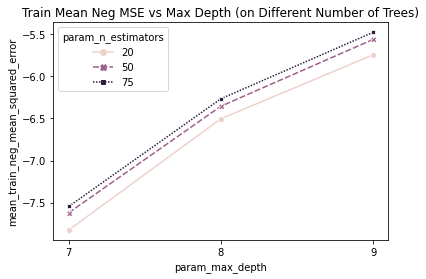

In [44]:
plt.figure()
pic = sns.lineplot(data=grid1_cvresult, x='param_max_depth', y='mean_train_neg_mean_squared_error', hue='param_n_estimators', ci=None, markers=True, style='param_n_estimators')
plt.xticks(np.arange(7,10))
plt.title('Train Mean Neg MSE vs Max Depth (on Different Number of Trees)')
plt.show()

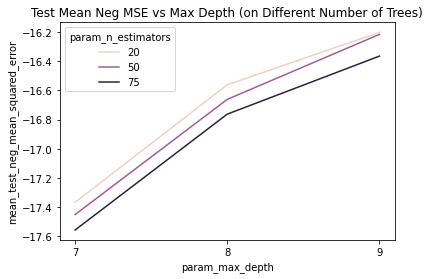

In [45]:
plt.figure()
pic = sns.lineplot(data=grid1_cvresult, x='param_max_depth', y='mean_test_neg_mean_squared_error', hue='param_n_estimators', ci=None, markers=True)
plt.xticks(np.arange(7,10))
plt.title('Test Mean Neg MSE vs Max Depth (on Different Number of Trees)')
plt.show()

Minimum Number of Samples on Leaf Node

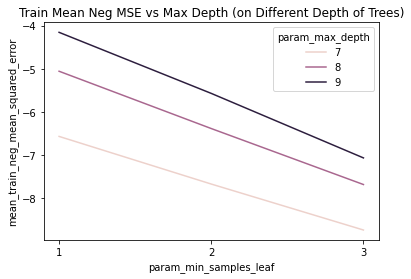

In [46]:
plt.figure()
pic = sns.lineplot(data=grid1_cvresult, x='param_min_samples_leaf', y='mean_train_neg_mean_squared_error', hue='param_max_depth', ci=None, markers=True)
plt.xticks(np.arange(1,4))
plt.title('Train Mean Neg MSE vs Max Depth (on Different Depth of Trees)')
plt.show()

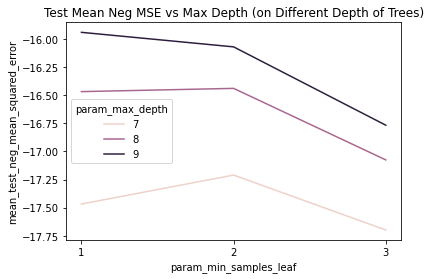

In [47]:
plt.figure()
pic = sns.lineplot(data=grid1_cvresult, x='param_min_samples_leaf', y='mean_test_neg_mean_squared_error', hue='param_max_depth', ci=None, markers=True)
plt.xticks(np.arange(1,4))
plt.title('Test Mean Neg MSE vs Max Depth (on Different Depth of Trees)')
plt.show()

Each splits' performance

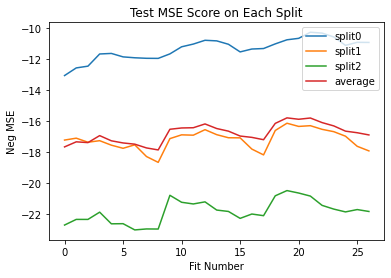

In [48]:
plt.figure()
plt.plot(grid1_cvresult['split0_test_neg_mean_squared_error'], label='split0')
plt.plot(grid1_cvresult['split1_test_neg_mean_squared_error'], label='split1')
plt.plot(grid1_cvresult['split2_test_neg_mean_squared_error'], label='split2')
plt.plot(grid1_cvresult['mean_test_neg_mean_squared_error'], label='average')
plt.title('Test MSE Score on Each Split')
plt.xlabel('Fit Number')
plt.ylabel('Neg MSE')
plt.legend()
plt.show()

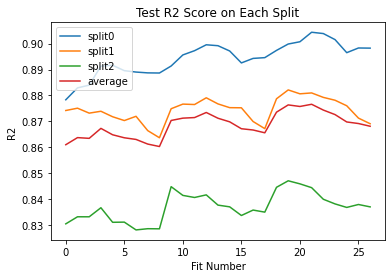

In [49]:
plt.figure()
plt.plot(grid1_cvresult['split0_test_r2'], label='split0')
plt.plot(grid1_cvresult['split1_test_r2'], label='split1')
plt.plot(grid1_cvresult['split2_test_r2'], label='split2')
plt.plot(grid1_cvresult['mean_test_r2'], label='average')
plt.title('Test R2 Score on Each Split')
plt.xlabel('Fit Number')
plt.ylabel('R2')
plt.legend()
plt.show()